In [16]:
import tensorflow as tf
import keras
import os
import numpy as np 
import pandas as pd
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import clear_output as cls

In [17]:
root_path = '/kaggle/input/animal-image-classification-dataset/Training Data/Training Data/'
class_names = ['Cat','Cow','Dog','Elephant', 'Gorilla', 'Hippo']
n_classes = len(class_names)

class_dis = [len(os.listdir(root_path + name)) for name in class_names]

print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 6 
Class Names : ['Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo']


In [18]:
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [19]:
valid_path = '/kaggle/input/animal-image-classification-dataset/Validation Data/Validation Data/'

class_dis = [len(os.listdir(valid_path + name)) for name in class_names]

fig = px.pie(names=class_names, values=class_dis, title="Validation Class Distribution", color=class_names, hole=0.2)
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [20]:
test_path = '/kaggle/input/animal-image-classification-dataset/Testing Data/Testing Data/'

class_dis = [len(os.listdir(test_path + name)) for name in class_names]

fig = px.pie(names=class_names, values=class_dis, title="Testing Class Distribution", color=class_names, hole=0.2)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [21]:
train_gen = ImageDataGenerator(rescale=1/255., rotation_range=10, horizontal_flip=True)
valid_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255)

train_ds = train_gen.flow_from_directory(root_path, class_mode='categorical', target_size=(224,224), shuffle=True, batch_size=32, classes = class_names) 
valid_ds = valid_gen.flow_from_directory(valid_path, class_mode='categorical', target_size=(224,224), shuffle=True, batch_size=32, classes = class_names) 
test_ds = test_gen.flow_from_directory(test_path, class_mode='categorical', target_size=(224,224), shuffle=True, batch_size=32, classes = class_names)

Found 12000 images belonging to 6 classes.
Found 600 images belonging to 6 classes.
Found 1052 images belonging to 6 classes.


In [22]:
def plot_learning_curves(history, lr):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss'+" Lr = "+lr)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy'+" Lr = "+lr)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [23]:
def show_images(GRID=[5,5], model=None, size=(20,20), data=train_ds):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    
    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(len(images))
        image, label = images[id], class_names[np.argmax(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
            cls()
            
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

Epoch 1/15
375/375 [==============================] - 211s 472ms/step - loss: 1.6317 - accuracy: 0.4137 - val_loss: 2.2880 - val_accuracy: 0.2533
Epoch 2/15
375/375 [==============================] - 167s 444ms/step - loss: 1.2197 - accuracy: 0.5494 - val_loss: 1.8832 - val_accuracy: 0.4000
Epoch 3/15
375/375 [==============================] - 166s 442ms/step - loss: 1.0577 - accuracy: 0.6105 - val_loss: 1.6294 - val_accuracy: 0.4250
Epoch 4/15
375/375 [==============================] - 165s 440ms/step - loss: 0.9442 - accuracy: 0.6558 - val_loss: 15.2527 - val_accuracy: 0.2933
Epoch 5/15
375/375 [==============================] - 163s 435ms/step - loss: 0.8906 - accuracy: 0.6833 - val_loss: 2.1748 - val_accuracy: 0.3667
Epoch 6/15
375/375 [==============================] - 166s 443ms/step - loss: 0.8434 - accuracy: 0.6998 - val_loss: 1.0137 - val_accuracy: 0.6467
Epoch 7/15
375/375 [==============================] - 164s 436ms/step - loss: 0.7914 - accuracy: 0.7225 - val_loss: 1.2164 

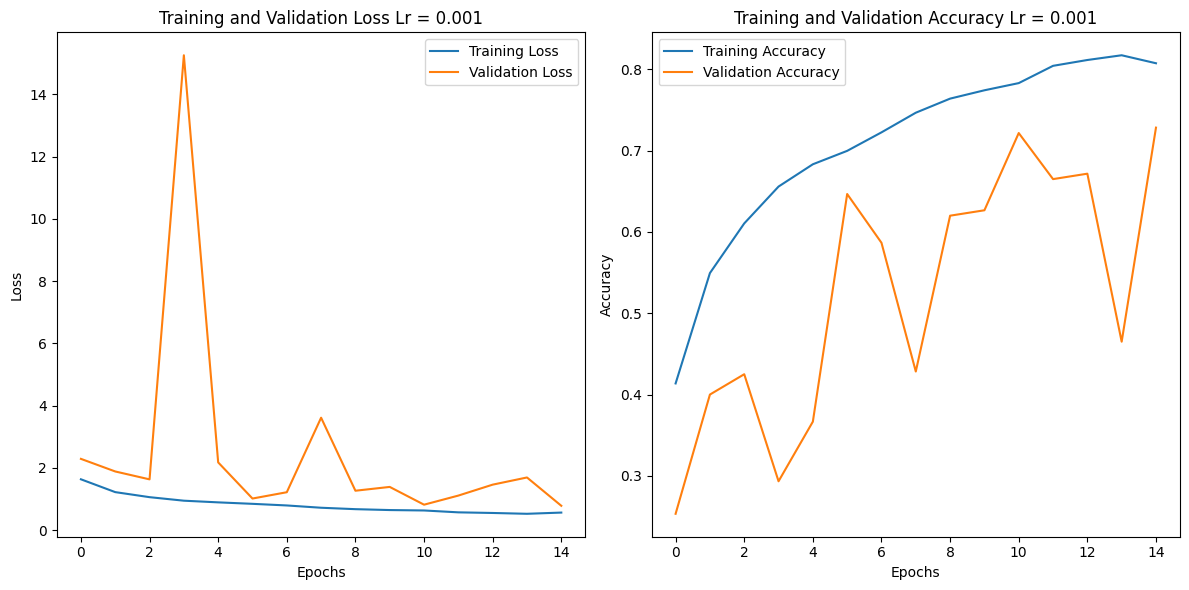

In [25]:
model_resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=True,weights = None, classes=6, classifier_activation='softmax')
epochs = 15
model_resnet50.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_checkpoint_callback  = tf.keras.callbacks.ModelCheckpoint(
        "/kaggle/working/resnet50_checkpoints/",
    monitor= 'val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    save_freq='epoch',
)

history_resnet50 = model_resnet50.fit(
    train_ds,
    epochs=epochs,
    callbacks=[model_checkpoint_callback],
    validation_data=valid_ds,
    verbose=1
)
plot_learning_curves(history_resnet50, "0.001")

In [26]:
model = history_resnet50.model

In [27]:
loss_val, accuracy = model.evaluate(test_ds)
print("Loss value = ", loss_val)
print("accuracy = ", accuracy)

33/33 [==============================] - 4s 117ms/step - loss: 0.9190 - accuracy: 0.7319
Loss value =  0.9190137386322021
accuracy =  0.7319391369819641


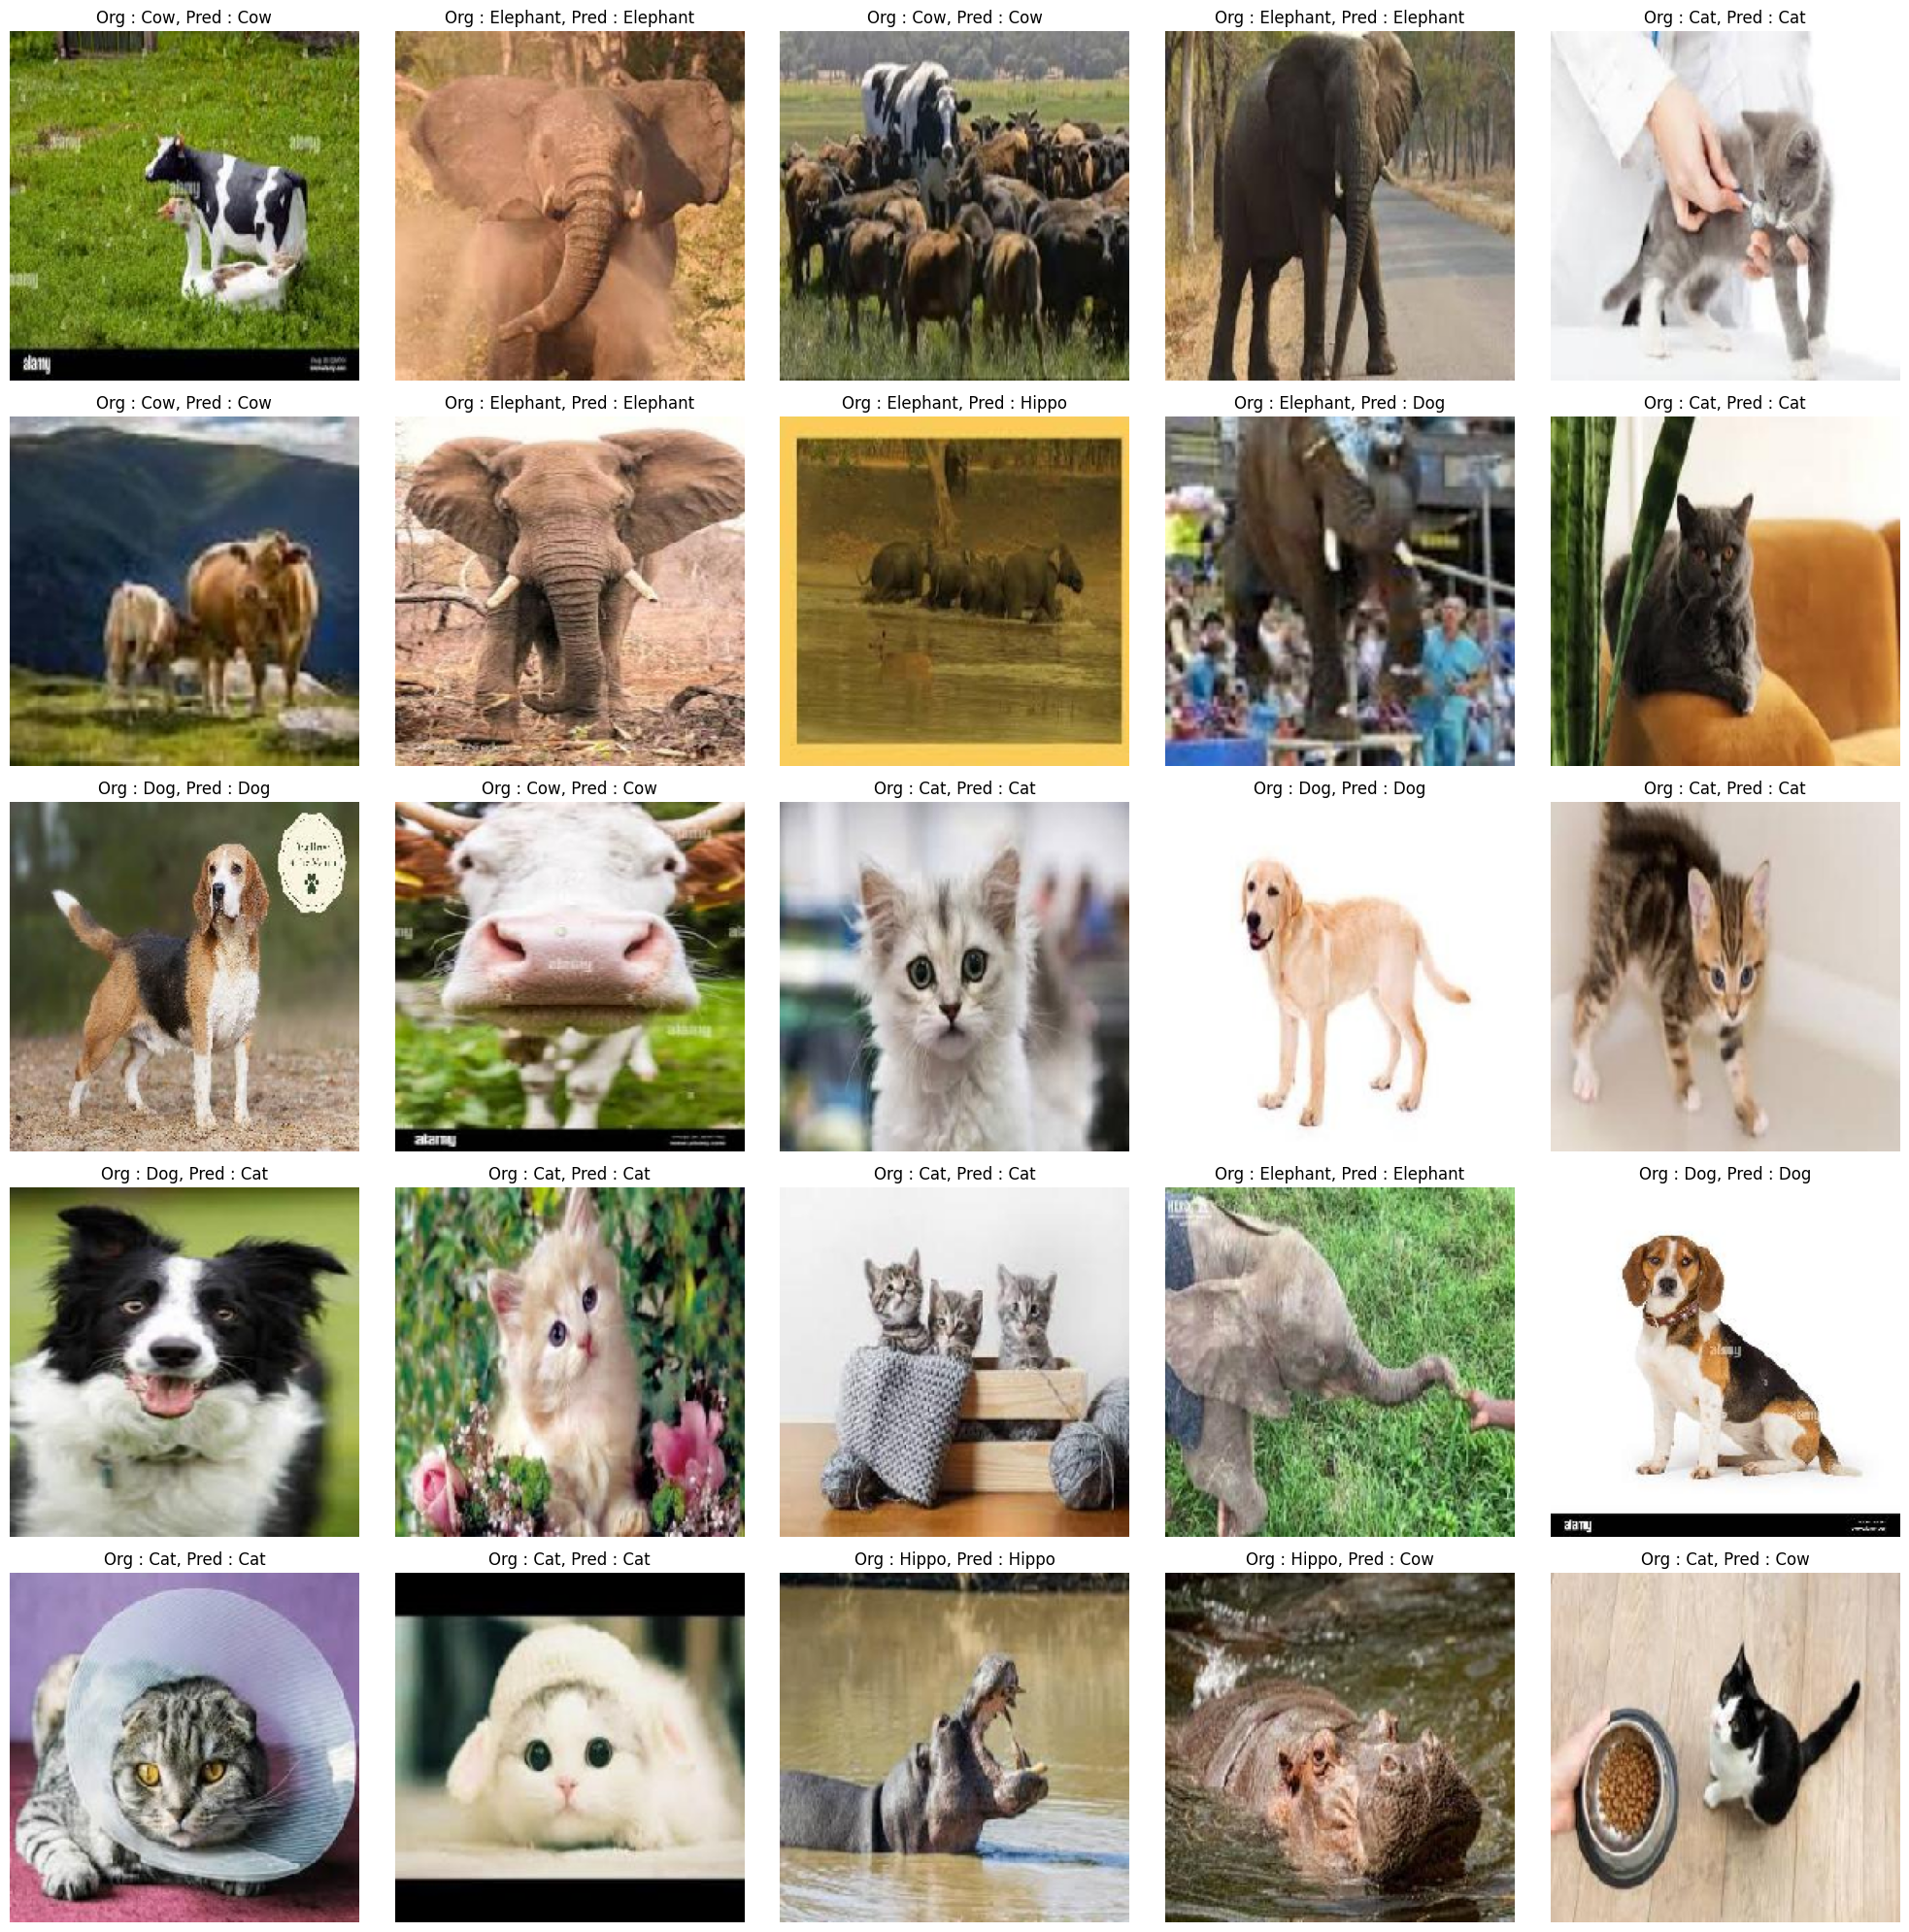

In [28]:
show_images(model=model, data=test_ds)

In [29]:
from sklearn.metrics import f1_score, classification_report

def calculate_f1_score_batch(model, images, labels):
    y_true = np.argmax(labels, axis=1)
    y_pred = np.argmax(model.predict(images), axis=1)

    f1_scores = f1_score(y_true, y_pred, average=None)
    avg_f1_score = f1_score(y_true, y_pred, average='weighted')  
    return f1_scores, avg_f1_score


1/1 [==============================] - 0s 33ms/step
F1 Scores for Model 1 (one batch): [0.7        0.66666667 0.28571429 0.66666667 0.92307692 0.66666667]
Average F1 Score for Model 1 (one batch): 0.6824290293040293


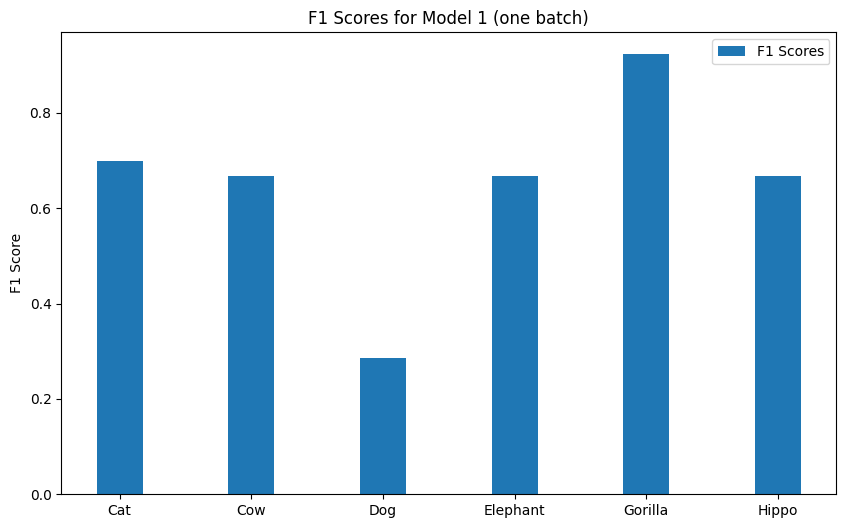

In [30]:
images_batch, labels_batch = next(iter(valid_ds))

f1_scores_batch, avg_f1_batch = calculate_f1_score_batch(model, images_batch, labels_batch)

print("F1 Scores for Model 1 (one batch):", f1_scores_batch)
print("Average F1 Score for Model 1 (one batch):", avg_f1_batch)

def plot_f1_scores_bar(f1_scores, class_names, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.35
    ind = np.arange(len(class_names))

    rects1 = ax.bar(ind, f1_scores, width, label='F1 Scores')

    ax.set_xticks(ind)
    ax.set_xticklabels(class_names)
    ax.legend()

    ax.set_ylabel('F1 Score')
    ax.set_title(title)

    plt.show()

plot_f1_scores_bar(f1_scores_batch, class_names, 'F1 Scores for Model 1 (one batch)')


In [31]:
model.save("ResNet_6.h5")
model.save("ResNet_6.keras")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

